In [1]:
import os
import pandas as pd
import keras
from keras import layers
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Bidirectional, LSTM


In [2]:
csv_path_long = 'Total_long_Utterance_file.csv'
df_long = pd.read_csv(csv_path_long)
df_long.head()

,FileName,Label
0,common_voice_en_38487408.wav,English
1,common_voice_en_38487411.wav,English
2,common_voice_en_38487412.wav,English
3,common_voice_en_38487413.wav,English
4,common_voice_en_38487414.wav,English


In [3]:
shuffled_df_long = df_long.sample(frac=1).reset_index(drop=True)
shuffled_df_long

,FileName,Label
0,common_voice_en_38502535.wav,English
1,common_voice_de_38531199.wav,German
2,common_voice_pt_38820330.wav,Portuguese
3,common_voice_en_38492702.wav,English
4,common_voice_en_38502637.wav,English
...,...,...
4994,common_voice_de_38531609.wav,German
4995,common_voice_de_38494805.wav,German
4996,common_voice_de_38527747.wav,German
4997,common_voice_fr_38132611.wav,French


In [4]:
csv_path_short = 'Total_short_Utterance_file.csv'
df_short = pd.read_csv(csv_path_short)
df_short.head()

,FileName,Label
0,common_voice_en_38487409.wav,English
1,common_voice_en_38487410.wav,English
2,common_voice_en_38487420.wav,English
3,common_voice_en_38487556.wav,English
4,common_voice_en_38491060.wav,English


In [5]:
shuffled_df_short = df_short.sample(frac=1).reset_index(drop=True)
shuffled_df_short

,FileName,Label
0,common_voice_ta_37342811.wav,Tamil
1,common_voice_ta_31864217.wav,Tamil
2,common_voice_pt_38490974.wav,Portuguese
3,common_voice_fr_38025291.wav,French
4,common_voice_en_38502334.wav,English
...,...,...
2495,common_voice_pt_38527914.wav,Portuguese
2496,common_voice_en_38512660.wav,English
2497,common_voice_de_38586597.wav,German
2498,common_voice_de_38620799.wav,German


In [6]:
audio_dir_long = 'LongShortUtteranceData/'
audio_dir_short = 'LongShortUtteranceData/'

In [7]:
def load_and_preprocess(file_path, start_time, end_time, sr=16000):
    audio, sr = librosa.load(file_path, sr=sr, offset=start_time, duration=end_time - start_time)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13,win_length = 512,hop_length = 256,n_fft = 512)#win_length = 32,hop_length = 256,n_fft = 512)
    return mfccs.T

In [8]:
# Create a list to store MFCCs and labels
mfccs_list = []
labels = []

In [9]:
for index, row in shuffled_df_long.iterrows():
    file_path = os.path.join(audio_dir_long, row['FileName'])
    audio_duration = librosa.get_duration(filename=file_path)
    
    offset = 0
    while offset < audio_duration:
        end_time = min(offset + 2.5, audio_duration)  # Ensure end_time does not exceed audio duration
        mfccs = load_and_preprocess(file_path, offset, end_time)
        mfccs_list.append(mfccs)
        labels.append(row['Label'])
        offset += 2.5

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14188\805225799.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  audio_duration = librosa.get_duration(filename=file_path)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14188\805225799.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  audio_duration = librosa.get_duration(filename=file_path)
C:\Users\ASUS\anaconda3\envs\LocalGpu\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=512 is too large for input signal of length=128
  warnings.warn(
C:\Users\ASUS\anaconda3\envs\LocalGpu\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=512 is too large for input signal of length=64
  warnings.warn(
C:\Users\ASUS\anaconda3\envs\LocalGpu\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=512 is too

In [10]:
print(len(mfccs_list))
print(len(labels))

14996
14996


In [11]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_mfccs_long = pad_sequences(mfccs_list, dtype='float32', padding='post', truncating='post')

print(padded_mfccs_long.shape)

(14996, 157, 13)


In [12]:
X = np.array(padded_mfccs_long)
y = np.array(labels)

In [13]:
le = LabelEncoder()
y_encoded_long = le.fit_transform(y)

In [14]:
print("Encoded Labels:")
for encoded_label, original_label in zip(range(len(le.classes_)), le.classes_):
    print(f"{encoded_label}: {original_label}")

Encoded Labels:
0: English
1: French
2: German
3: Portuguese
4: Tamil


In [15]:
# Split the data into 80% training and 20% remaining data
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y_encoded_long, test_size=0.2, random_state=42)

# Split the remaining data into 50% validation and 50% test
X_validation, X_test, y_validation, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)

In [16]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    
    def call(self, inputs):
        # Forward pass of the student model
        return self.student(inputs)
    
    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results
    def predict_step(self, data):
        # Unpack the data
        x = data

        # Compute predictions
        return self.student(x, training=False)

In [17]:
from tensorflow.keras import layers

def swish(x, name=None):
    return x * tf.sigmoid(x)

teacher = keras.Sequential(
    [  
        layers.Conv2D(32, (3, 3), activation=swish, padding='same', input_shape=(X.shape[1], X.shape[2], 1)),
        layers.Conv2D(32, (3, 3), activation=swish, padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation=swish, padding='same'),
        layers.Conv2D(64, (3, 3), activation=swish, padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation=swish, padding='same'),
        layers.Conv2D(128, (3, 3), activation=swish, padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(128, activation=swish),
        layers.Dropout(0.3),
        layers.Dense(64, activation=swish),
        layers.Dropout(0.3),
        
        layers.Dense(5, activation='softmax')
    ],
    name="teacher",
)



In [18]:

student = keras.Sequential(
    [  
        layers.Conv2D(16, (3, 3), activation=swish, padding='same', input_shape=(X.shape[1], X.shape[2], 1)),
        layers.Conv2D(16, (3, 3), activation=swish, padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
        layers.Dropout(0.25),

        layers.Conv2D(32, (3, 3), activation=swish, padding='same'),
        layers.Conv2D(32, (3, 3), activation=swish, padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation=swish, padding='same'),
        layers.Conv2D(64, (3, 3), activation=swish, padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(128, activation=swish),
        layers.Dropout(0.3),
        layers.Dense(64, activation=swish),
        layers.Dropout(0.3),
        
        layers.Dense(5, activation='softmax')
    ],
    name="student",
)

In [19]:
teacher.summary()

Model: "teacher"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 157, 13, 32)       320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 157, 13, 32)       9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 157, 13, 32)       128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 79, 7, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 79, 7, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 79, 7, 64)         18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 79, 7, 64)         3692

In [20]:
student.summary()

Model: "student"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 157, 13, 16)       160       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 157, 13, 16)       2320      
_________________________________________________________________
batch_normalization_3 (Batch (None, 157, 13, 16)       64        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 79, 7, 16)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 79, 7, 16)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 79, 7, 32)         4640      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 79, 7, 32)         9248

In [21]:
X_train = X_train.reshape(X_train.shape + (1,))
X_test = X_test.reshape(X_test.shape + (1,))
X_validation = X_validation.reshape(X_validation.shape + (1,))


In [22]:
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import LearningRateScheduler

# Define the learning rate schedule function
def lr_schedule(epoch):
    learning_rate = 0.001  # Initial learning rate
    if epoch >= 150:
        learning_rate *= 0.5e-3
    elif epoch >= 100:
        learning_rate *= 1e-3
    elif epoch >= 50:
        learning_rate *= 1e-2
    return learning_rate


# Compile teacher model with RMSprop optimizer
teacher.compile(
    optimizer=RMSprop(learning_rate=0.001),  # Initial learning rate
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)



# Train and evaluate teacher on data with learning rate schedule
history = teacher.fit(
    X_train,
    y_train,
    epochs=150,
    validation_data=(X_validation, y_validation),
    callbacks=[LearningRateScheduler(lr_schedule)],
)

# Evaluate the teacher model on test data
evaluation_result = teacher.evaluate(X_test, y_test)


Epoch 1/150


C:\Users\ASUS\anaconda3\envs\LocalGpu\lib\site-packages\keras\backend.py:4906: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


375/375 [==============================] - 21s 19ms/step - loss: 1.5994 - sparse_categorical_accuracy: 0.3465 - val_loss: 1.2754 - val_sparse_categorical_accuracy: 0.3807
Epoch 2/150
375/375 [==============================] - 6s 16ms/step - loss: 1.3080 - sparse_categorical_accuracy: 0.3998 - val_loss: 1.2534 - val_sparse_categorical_accuracy: 0.4000
Epoch 3/150
375/375 [==============================] - 6s 16ms/step - loss: 1.2190 - sparse_categorical_accuracy: 0.4418 - val_loss: 1.1708 - val_sparse_categorical_accuracy: 0.4520
Epoch 4/150
375/375 [==============================] - 6s 16ms/step - loss: 1.1533 - sparse_categorical_accuracy: 0.4837 - val_loss: 1.0118 - val_sparse_categorical_accuracy: 0.5707
Epoch 5/150
375/375 [==============================] - 6s 16ms/step - loss: 1.0897 - sparse_categorical_accuracy: 0.5162 - val_loss: 1.4630 - val_sparse_categorical_accuracy: 0.4700
Epoch 6/150
375/375 [==============================] - 6s 16ms/step - loss: 1.0360 - sparse_categoric

In [23]:
# Print the evaluation result
print("Evaluation Loss: {:.4f}".format(evaluation_result[0]))
print("Evaluation Accuracy: {:.2f}%".format(evaluation_result[1] * 100))

Evaluation Loss: 0.3822
Evaluation Accuracy: 90.60%


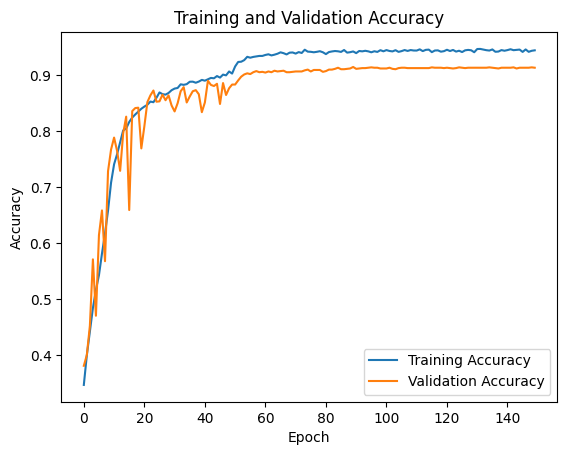

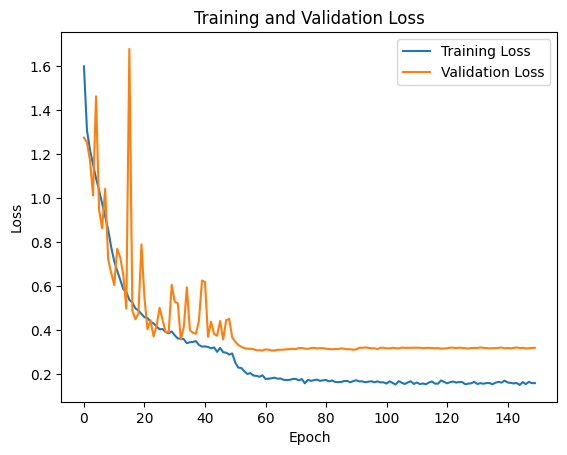

In [24]:
# Plotting training and validation accuracy
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plotting training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

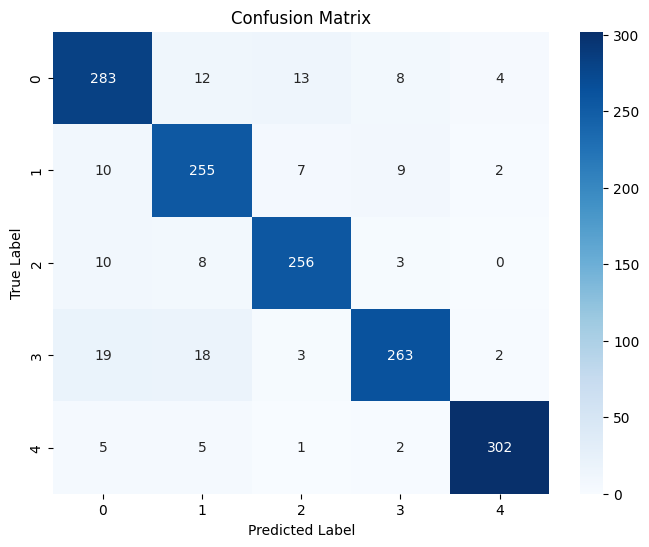

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87       320
           1       0.86      0.90      0.88       283
           2       0.91      0.92      0.92       277
           3       0.92      0.86      0.89       305
           4       0.97      0.96      0.97       315

    accuracy                           0.91      1500
   macro avg       0.91      0.91      0.91      1500
weighted avg       0.91      0.91      0.91      1500



In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred_teacher = np.argmax(teacher.predict(X_test), axis=1)

# True labels
y_true = y_test

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred_teacher)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_teacher))

In [26]:
# Save the trained teacher model
teacher.save('2D_CNN_teacher_model.keras')

## Student Model Training

In [27]:
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

# Distill teacher to student and store the training history
history_distill = distiller.fit(X_train, y_train, epochs=150, validation_data=(X_validation, y_validation))


Epoch 1/150


C:\Users\ASUS\anaconda3\envs\LocalGpu\lib\site-packages\keras\backend.py:4906: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


375/375 [==============================] - 8s 15ms/step - sparse_categorical_accuracy: 0.3375 - student_loss: 1.4815 - distillation_loss: 0.0691 - val_sparse_categorical_accuracy: 0.3807 - val_student_loss: 1.1863
Epoch 2/150
375/375 [==============================] - 5s 13ms/step - sparse_categorical_accuracy: 0.4151 - student_loss: 1.2548 - distillation_loss: 0.0605 - val_sparse_categorical_accuracy: 0.4687 - val_student_loss: 1.0950
Epoch 3/150
375/375 [==============================] - 5s 13ms/step - sparse_categorical_accuracy: 0.4832 - student_loss: 1.1736 - distillation_loss: 0.0563 - val_sparse_categorical_accuracy: 0.5387 - val_student_loss: 1.0170
Epoch 4/150
375/375 [==============================] - 5s 13ms/step - sparse_categorical_accuracy: 0.5167 - student_loss: 1.1088 - distillation_loss: 0.0528 - val_sparse_categorical_accuracy: 0.4487 - val_student_loss: 1.0030
Epoch 5/150
375/375 [==============================] - 5s 13ms/step - sparse_categorical_accuracy: 0.5430 - 

In [34]:
evaluation_result = distiller.evaluate(X_test, y_test)

47/47 [==============================] - 0s 8ms/step - sparse_categorical_accuracy: 0.9033 - student_loss: 0.4054


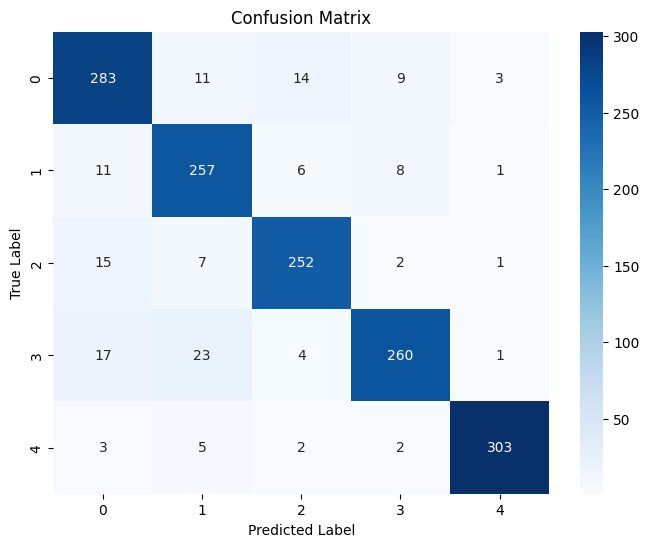

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       320
           1       0.85      0.91      0.88       283
           2       0.91      0.91      0.91       277
           3       0.93      0.85      0.89       305
           4       0.98      0.96      0.97       315

    accuracy                           0.90      1500
   macro avg       0.90      0.90      0.90      1500
weighted avg       0.90      0.90      0.90      1500



In [37]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred_distill = np.argmax(distiller.predict(X_test), axis=1)

# True labels
y_true = y_test

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred_distill)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_distill))

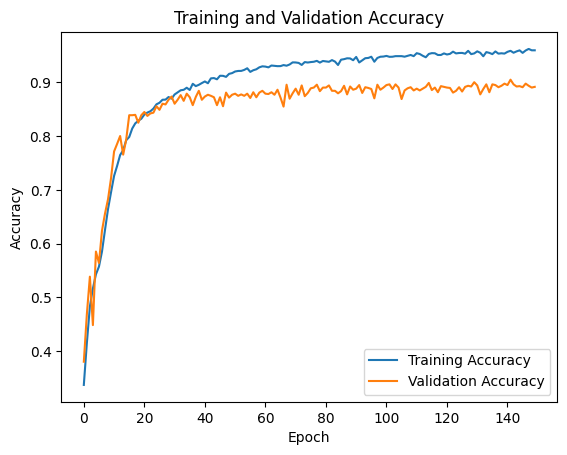

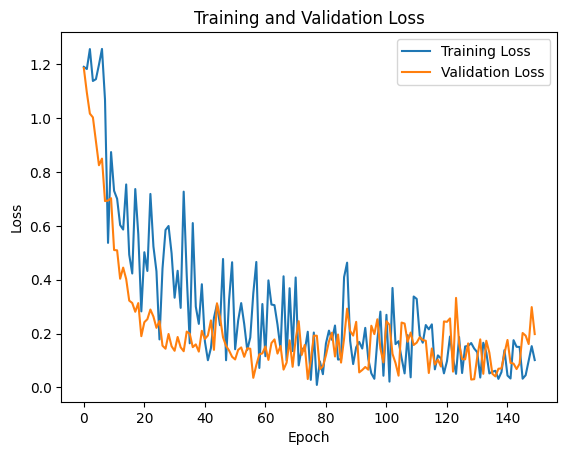

In [36]:
# Plotting training and validation accuracy
plt.plot(history_distill.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history_distill.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plotting training and validation loss
plt.plot(history_distill.history['student_loss'], label='Training Loss')
plt.plot(history_distill.history['val_student_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [38]:
# Save the student model as a .keras file
distiller.student.save('2D_CNN_student_model.keras')

## Testing on short utterance

In [39]:
test_dir = 'LongShortUtteranceData/'

In [40]:
test_df = pd.read_csv("Total_short_Utterance_file.csv")
test_df.head()

,FileName,Label
0,common_voice_en_38487409.wav,English
1,common_voice_en_38487410.wav,English
2,common_voice_en_38487420.wav,English
3,common_voice_en_38487556.wav,English
4,common_voice_en_38491060.wav,English


In [41]:
mfccs_list_test = []
labels_test = []

In [42]:
for index, row in test_df.iterrows():
    file_path = os.path.join(test_dir, row['FileName'])
    audio_duration = librosa.get_duration(filename=file_path)
    
    offset = 0
    while offset < audio_duration:
        end_time = min(offset + 2.5, audio_duration)  # Ensure end_time does not exceed audio duration
        mfccs = load_and_preprocess(file_path, offset, end_time)
        mfccs_list_test.append(mfccs)
        labels_test.append(row['Label'])
        offset += 2.5

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14188\1168826159.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  audio_duration = librosa.get_duration(filename=file_path)
C:\Users\ASUS\anaconda3\envs\LocalGpu\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=512 is too large for input signal of length=320
  warnings.warn(


In [43]:
print(len(mfccs_list_test))
print(len(labels_test))

4645
4645


In [44]:

padded_mfccs_test = pad_sequences(mfccs_list_test, dtype='float32', padding='post', truncating='post')

print(padded_mfccs_test.shape)

(4645, 157, 13)


In [45]:
X_test_short = np.array(padded_mfccs_test)
y_test_short = np.array(labels_test)

In [46]:
le = LabelEncoder()
y_encoded = le.fit_transform(y_test_short)

In [47]:
X_test_short = X_test_short.reshape(X_test_short.shape + (1,))

In [48]:
evaluation_result = teacher.evaluate(X_test_short, y_encoded)

146/146 [==============================] - 1s 8ms/step - loss: 1.8426 - sparse_categorical_accuracy: 0.6652


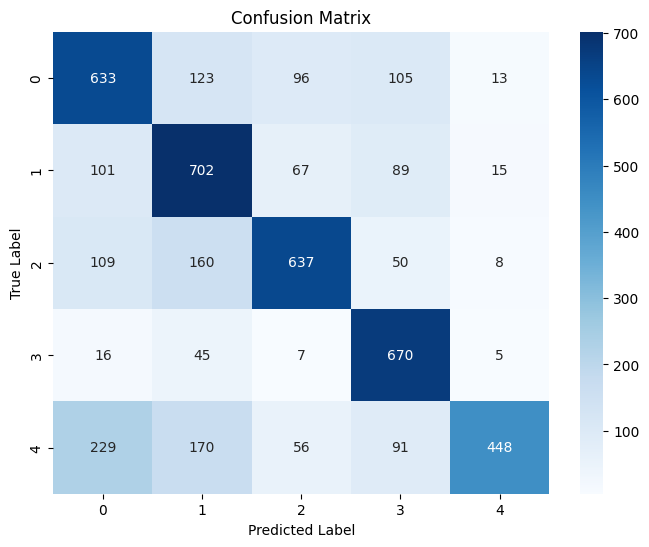

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.65      0.62       970
           1       0.58      0.72      0.65       974
           2       0.74      0.66      0.70       964
           3       0.67      0.90      0.77       743
           4       0.92      0.45      0.60       994

    accuracy                           0.67      4645
   macro avg       0.70      0.68      0.67      4645
weighted avg       0.70      0.67      0.66      4645



In [49]:
y_pred_teacher = np.argmax(teacher.predict(X_test_short), axis=1)

# True labels
y_true = y_encoded

# Create confusion matrix
cm = confusion_matrix(y_encoded, y_pred_teacher)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_teacher))

In [50]:
evaluation_result = distiller.evaluate(X_test_short, y_encoded)

146/146 [==============================] - 1s 5ms/step - sparse_categorical_accuracy: 0.6538 - student_loss: 1.8796


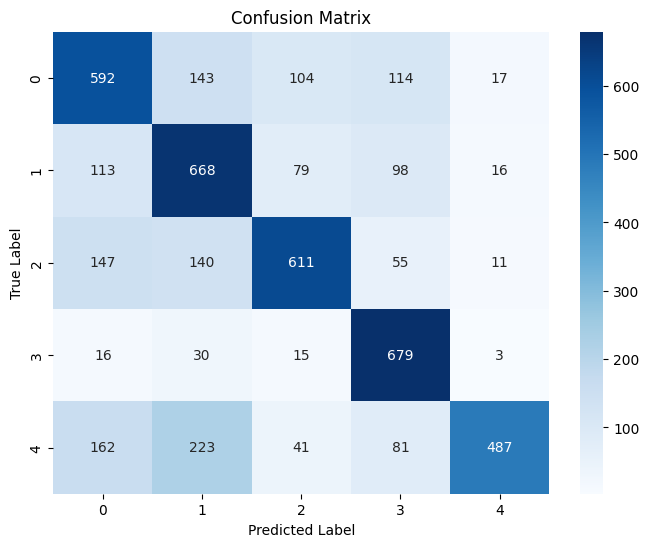

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.61      0.59       970
           1       0.55      0.69      0.61       974
           2       0.72      0.63      0.67       964
           3       0.66      0.91      0.77       743
           4       0.91      0.49      0.64       994

    accuracy                           0.65      4645
   macro avg       0.68      0.67      0.66      4645
weighted avg       0.69      0.65      0.65      4645



In [52]:

y_pred_student = np.argmax(distiller.predict(X_test_short), axis=1)

# True labels
y_true = y_encoded

# Create confusion matrix
cm = confusion_matrix(y_encoded, y_pred_student)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_student))